# Step 7：Data Mining

# Random Forest Model

In [1]:
# Must be included at the beginning of each new notebook. Remember to change the app name.
import findspark
findspark.init('/home/ubuntu/spark-3.2.1-bin-hadoop2.7')
import pyspark
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName('DBAS-Step7-DM-RandomForest').getOrCreate()

# Enable pandas-on-Spark
spark.conf.set("spark.sql.execution.arrow.pyspark.enabled", "true")

Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
23/10/10 23:37:06 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [2]:
## Load data from csv file
spk_df = spark.read.csv("Data/4DT/heart_failure_dataset_4DT.csv", header=True, inferSchema=True)

# Convert Spark DataFrame to pandas-on-Spark DataFrame using to_pandas_on_spark()
spkpd_df = spk_df.to_pandas_on_spark()
spkpd_df.info()


/home/ubuntu/.local/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.0
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
23/10/10 23:37:17 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/10/10 23:37:17 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.


<class 'pyspark.pandas.frame.DataFrame'>
Int64Index: 383 entries, 0 to 382
Data columns (total 6 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   creatinine_phosphokinase  383 non-null    int32  
 1   ejection_fraction         383 non-null    int32  
 2   platelets                 383 non-null    float64
 3   serum_creatinine          383 non-null    float64
 4   serum_sodium              383 non-null    int32  
 5   DEATH_EVENT               383 non-null    int32  
dtypes: float64(2), int32(4)

In [3]:
### --------  06-DMA

# Load relevant algorithms for Random Forest model

from pyspark.sql import SparkSession
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
import matplotlib.pyplot as plt

In [4]:
# Prepare data for MLlib
feature_cols = [col for col in spk_df.columns if col != 'DEATH_EVENT']
assembler = VectorAssembler(inputCols=feature_cols, outputCol="features")
df_assembled = assembler.transform(spk_df)

# Split the data into training and test sets
(train_data, test_data) = df_assembled.randomSplit([0.7, 0.3], seed=42)

# Train using Random Forest
clf = RandomForestClassifier(numTrees=100, labelCol="DEATH_EVENT", featuresCol="features", seed=42)
model = clf.fit(train_data)


In [5]:
# Predict and evaluate accuracy
predictions = model.transform(test_data)
evaluator = MulticlassClassificationEvaluator(labelCol="DEATH_EVENT", 
                                              predictionCol="prediction", 
                                              metricName="accuracy")

accuracy = evaluator.evaluate(predictions)
print(f"Test Accuracy of Random Forest: {accuracy*100:.2f}%")

Test Accuracy of Random Forest: 78.95%


Feature importance using Random Tree:
serum_creatinine: 0.3345
ejection_fraction: 0.2854
serum_sodium: 0.1513
creatinine_phosphokinase: 0.1284
platelets: 0.1003


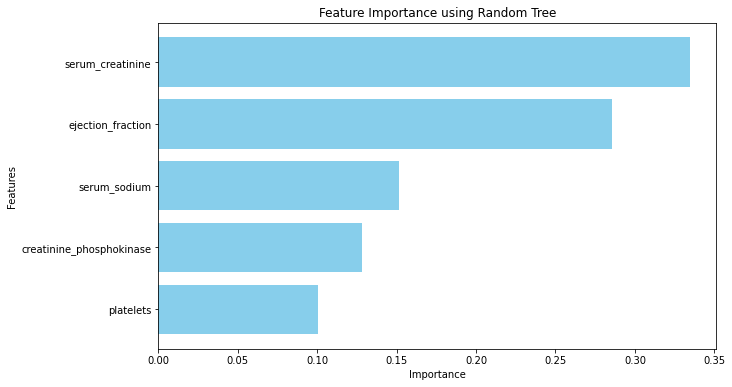

In [6]:
# Get feature importances
feature_importances = model.featureImportances.toArray()

# Sort features based on importance and print them
important_features = sorted(zip(feature_cols, feature_importances), key=lambda x: x[1], reverse=True)
print("Feature importance using Random Tree:")
for feature, importance in important_features:
    print(f"{feature}: {importance:.4f}")
    
# Plotting feature importance
features, importances = zip(*important_features)
plt.figure(figsize=(10, 6)) 
plt.barh(features, importances, align='center', color='skyblue')
plt.xlabel('Importance')
plt.ylabel('Features')
plt.title('Feature Importance using Random Tree')
plt.gca().invert_yaxis()  # Display the most important feature at the top
plt.show()


In [7]:
# Stop Spark session
spark.stop()